# Google Play Store Apps | Kaggle

## Introduction

This dataset was webscaped from the Google Play Store and made available on Kaggle. It contains ratings, reviews, category, genre, and number of installs to describe apps made available in the app store.

Since I'm an android user, I thought it was be interesting to see how my preferences compare with the majority of android users. I have only bought one android app (game), so I'm curious to see how popular and "better" the paid apps are in comparison to the free versions.

## 2 Datasets:
* googleplaystore.csv
* googlepaystore_user_reviews.csv

In [1]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import re

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read first dataset
df = pd.read_csv("data/googleplaystore.csv")
print(df.shape)
df.head(1)

(10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up


In [3]:
# Read second dataset
d = pd.read_csv("data/googleplaystore_user_reviews.csv")
print(d.shape)
d.head(1)

(64295, 5)


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.0,0.533333


## Data Cleaning

### First Dataset

In [4]:
# Check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Rename dataframe columns to lowercase.

In [5]:
# Change column names to lowercase
df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
d.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

Change `df.reviews` to `int` datatype.

In [6]:
# Check which entries in reviews cannot be casted as integer
for i in list(df.reviews):
    try:
        int(i)
    except:
        print(i)

3.0M


In [7]:
# Fix the 3.0M to 3000000 and cast all values as integer
df.reviews = df.reviews.apply(lambda x: x.replace("3.0M","3000000")).astype(int)

Change `df.size` to `float` in kB.

In [8]:
# Check what non-numeric characters exist other than M
df[~df['size'].str.contains("k")]["size"].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '3.6M',
       '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M', '8.9M',
       '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M', '2.2M',
       '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M', '7.1M',
       '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M', '4.9M',
       '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M', '4.0M',
       '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M', '6.5M',
       '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M', '8.3M', '4.3M',
       '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M', '5.1M', '61M',
       '66M', '8.4M', '44M', '1.6M', '6.2M', '53M', '1.4M', '3.0M',
       '5.8M

In [9]:
# Change all values to kb unit of measure
def kb_transform(x):
    # Replace 'Varies with device' with NaN
    if x =='Varies with device':
        return np.nan 
    # Convert all 'M to 'k
    elif 'M' in x:
        return float(x[:-1])*1000
    # Remove '+
    elif '+' in x:
        return float(x[:-1])

df["size"] = df["size"].apply(lambda x: kb_transform(x.replace(",","")))

Change `df.installs` to `float`.

In [10]:
# Check what non-numeric characters exist other than +
df[~df['installs'].str.contains("\+")]["installs"].unique()

array(['0', 'Free'], dtype=object)

In [11]:
# Remove '+'
df.installs = df.installs.str.replace("+","")

# Change 'Free' to NaN
df.installs = df.installs.replace("Free", np.nan)

# Remove all ','
df.installs = df.installs.str.replace(",", "")

# Convert to int datatype
df.installs = df.installs.astype(float)

Change `df.price` to `float` datatype.

In [12]:
# Remove '$'
df.price = df.price.str.replace("$","")

# Replace 'Everyone' with 0
df.price = df.price.str.replace("Everyone","0")

# Convert to float
df.price = df.price.astype(float)

**Feature Engineering:** Create a `price_type` field indicating whether the app is free or paid.

In [13]:
# Create price_type field
df["price_type"] = df.price.apply(lambda x: "paid" if x > 0 else "free")

Change `df.last_updated` to `date` type.

In [14]:
# Convert to datetime
def date_transform(txt):
    if re.search(",", txt):
        return datetime.strptime(txt, '%B %d, %Y')
    else: # Print invalid values
        print(txt)
        return np.nan

df.last_updated = df.last_updated.apply(lambda x: date_transform(x))

1.0.19


There are some duplicate apps in the dataset, which is caused by different `category`, `genres`, or `reviews`.
There is 1 `category` or `reviews` value per record, but there are up to 2 `genres` per record which is separated by a colon `;`. For cleaning, I'm going to assume that apps are unique by name.

Remove duplicate `reviews` by averaging the `reviews` for each app.

In [15]:
# Average reviews
df.reviews = df.groupby('app')['reviews'].transform('mean')
df.drop_duplicates(inplace=True)

Create a `genres_primary` and `genres_secondary` field for the genre before and after the semicolon `;`.

In [16]:
# Extract string before and after semicolon
def genres_transform(txt, before=True):
    if before:
        return txt[0]
    else:
        if len(txt) == 1:
            return np.nan
        else:
            return txt[1]

df["genres_primary"] = df.genres.apply(lambda x: genres_transform(x.split(";"), before=True))
df["genres_secondary"] = df.genres.apply(lambda x: genres_transform(x.split(";"), before=False))

# Drop old genres column
df.drop(columns="genres", inplace=True)

The cleaned dataset `df` is unique by `app` and `category`.

Drop some invalid records:
* App should have a valid category and genre --> Remove app `Life Made WI-Fi Touchscreen Photo Frame` because the category is "1.9"
* App should have a valid rating (scale of 1 to 5) --> Remove apps with a rating under 1 or above 5

In [17]:
# Remove invalid entry #1
df = df[(df.category != "1.9")]

# Remove invalid entry #2
df = df[(df.rating >= 1) & (df.rating <= 5)]

In [18]:
# Sanity check the numbers
df.describe()

,rating,reviews,size,installs,price
count,8317.000000,8.317000e+03,6852.000000,8.317000e+03,8317.000000
mean,4.175640,2.874299e+05,22704.903678,1.007346e+07,1.023985
std,0.533945,2.104251e+06,22863.435120,6.217315e+07,16.735363
min,1.000000,1.000000e+00,1000.000000,1.000000e+00,0.000000
25%,4.000000,1.310000e+02,5500.000000,1.000000e+04,0.000000
50%,4.300000,3.309000e+03,14000.000000,1.000000e+05,0.000000
75%,4.500000,4.764400e+04,32000.000000,1.000000e+06,0.000000
max,5.000000,7.814326e+07,100000.000000,1.000000e+09,400.000000


In [19]:
# See apps with price over $50
df[df.price > 50].head()

,app,category,rating,reviews,size,installs,type,price,content_rating,last_updated,current_ver,android_ver,price_type,genres_primary,genres_secondary
2253,Vargo Anesthesia Mega App,MEDICAL,4.6,92.0,32000.0,1000.0,Paid,79.99,Everyone,2018-06-18,19.0,4.0.3 and up,paid,Medical,NaN
4197,most expensive app (H),FAMILY,4.3,6.0,1500.0,100.0,Paid,399.99,Everyone,2018-07-16,1.0,7.0 and up,paid,Entertainment,NaN
4362,💎 I'm rich,LIFESTYLE,3.8,718.0,26000.0,10000.0,Paid,399.99,Everyone,2018-03-11,1.0.0,4.4 and up,paid,Lifestyle,NaN
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275.0,7300.0,10000.0,Paid,400.00,Everyone,2018-05-03,1.0.1,4.1 and up,paid,Lifestyle,NaN
5351,I am rich,LIFESTYLE,3.8,3547.0,1800.0,100000.0,Paid,399.99,Everyone,2018-01-12,2.0,4.0.3 and up,paid,Lifestyle,NaN


It's unreasonable to pay for an app from Google Play Store for $400. Most of these apps are a scam and playoff of the ["I'm Rich" App](https://www.guidingtech.com/68345/most-expensive-android-app/). The **Medical** apps might be priced high but real. 

Remove these "I'm Rich" apps.

In [20]:
# Keep apps with price under $30 or with category as MEDICAL
df = df[(df.price < 30) | (df.category == "MEDICAL")]

## Data Exploration

#### What is the distribution by category and genre?

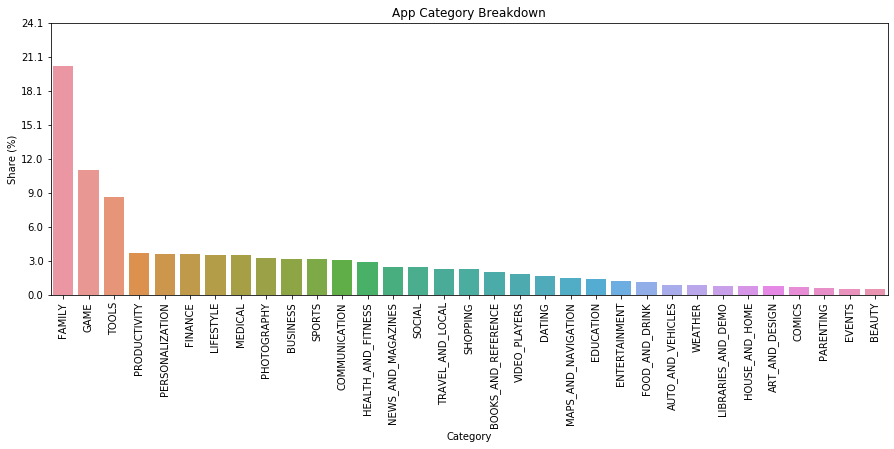

In [21]:
# Plot category bar plot
plt.figure(figsize=[15,5]);

p = df.category.value_counts().rename_axis('category').reset_index(name='counts')
sns.barplot(data=p, x="category", y="counts");

plt.title("App Category Breakdown");
plt.xlabel("Category");
plt.xticks(rotation=90);
plt.ylabel("Share (%)");
plt.yticks(np.arange(9)*250,np.around(np.arange(9)*250/df.shape[0]*100,decimals=1));

**Family** is the largest category close to 20%. The second largest category is **Game** around 10%. The third largest category is **Tools** at 8%. Family and Game might be share the same apps if they are kid-oriented, which explains why they make up the majority. There are also a lot of mobile game companies developing games, whereas not as many developers create Weather apps or Dating apps.

The next few categories are under 5%. We have some solid/go-to apps like Google Maps, AirBnB, or Uber/Lyft, and those categories tend to have fewer options in their space.

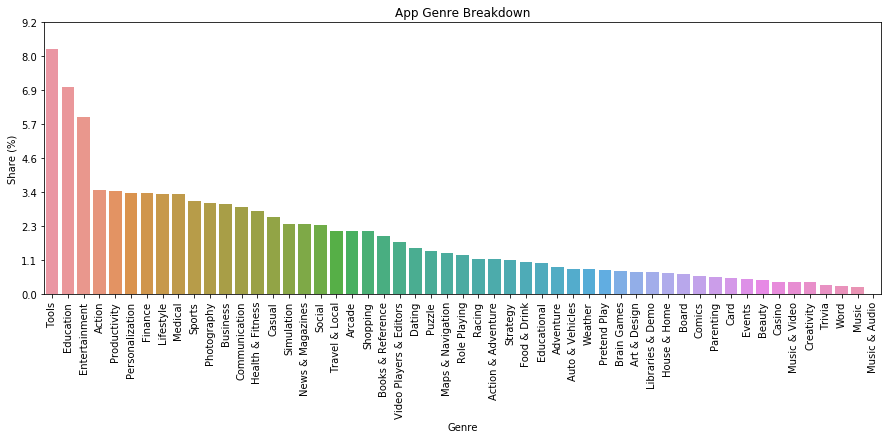

In [22]:
# Transform df to unstack genres
stack1 = df.drop(columns="genres_secondary").rename(columns={"genres_primary":"genres"})
stack2 = df.drop(columns="genres_primary").rename(columns={"genres_secondary":"genres"})
stack2 = stack2[~stack2.genres.isna()]
df_genres = pd.concat([stack1, stack2])

# Plot genres bar plot
plt.figure(figsize=[15,5]);

p = df_genres.genres.value_counts().rename_axis('genres').reset_index(name='counts')
sns.barplot(data=p, x="genres", y="counts");

plt.title("App Genre Breakdown");
plt.xlabel("Genre");
plt.xticks(rotation=90);
plt.ylabel("Share (%)");
plt.yticks(np.arange(9)*100,np.around(np.arange(9)*100/df_genres.shape[0]*100,decimals=1));

**Tools** is the largest genre making up 8% of the Google Play Store. **Education** is 7% and **Entertainment** is 6% as the second and third largest, respectively. Compared with categories, genres are more fragmented or varied in the app store.

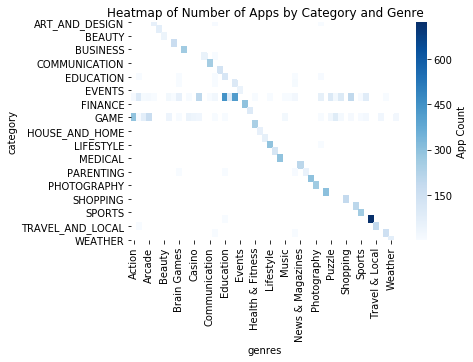

In [23]:
# Transform df to unstack genres
stack1 = df.drop(columns="genres_secondary").rename(columns={"genres_primary":"genres"})
stack2 = df.drop(columns="genres_primary").rename(columns={"genres_secondary":"genres"})
stack2 = stack2[~stack2.genres.isna()]
df_genres = pd.concat([stack1, stack2]).drop_duplicates()

# Count and pivot the number of apps under each category x genre
df_genres = df_genres.groupby(["category","genres"]).count().app.reset_index()
df_genres = df_genres.pivot(index="category",columns="genres",values="app")

# Plot correlation plot
sns.heatmap(data = df_genres, cbar_kws={'label':'App Count'}, cmap="Blues");
plt.title("Heatmap of Number of Apps by Category and Genre");

Not the most useful graph, but there are some obviously overlapping categories and genres. Both categories and genres have the label **Tools** with a high app count. **Video Players** category and **Video Players & Editors** genre share a high app count within their own share of category/genre.

The **Family** category also shows similar or correlated genres, like **Education** or **Food & Drink**.

#### What is the distribution of ratings?

The average rating is 4.2.


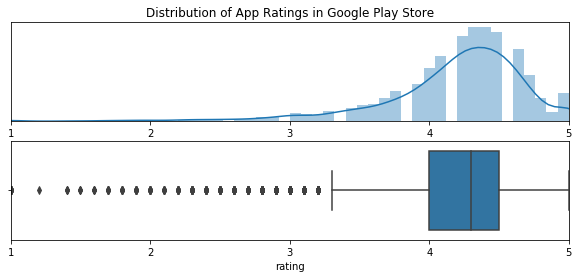

In [24]:
# Dedupe dataframe to get one rating per app
df_rating = df[["app","rating"]].drop_duplicates().dropna()
print("The average rating is {}.".format(round(df_rating.rating.mean(),1)))

# Create figure
fig, axes = plt.subplots(2, 1, figsize=[10,4])

# Plot histogram
plt.sca(axes[0])
plt.title("Distribution of App Ratings in Google Play Store");
sns.distplot(df_rating["rating"]);
plt.xlim(1,5);
plt.xticks(np.arange(5)+1);
plt.yticks([]);

# Plot box + whisker
plt.sca(axes[1])
sns.boxplot(df_rating["rating"]);
plt.xlim(1,5);
plt.xticks(np.arange(5)+1);

Most apps have a positive rating with the median at **4.3** and mean at **4.2**. The majority of apps have at least a 4-star rating, fewer have 3-star ratings. 

#### What is the distribution of installs?

The average number of installs is 9195163.0.


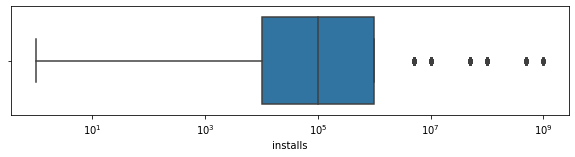

In [25]:
# Dedupe dataframe to get one install per app
df_install = df[["app","installs"]].drop_duplicates().dropna()
print("The average number of installs is {}.".format(round(df_install.installs.mean())))

# Plot box + whisker
plt.figure(figsize=[10,2])
sns.boxplot(df_install["installs"]);
plt.xscale('log');

App installs have a wide range, but most apps in this dataset have 10,000 installs. 

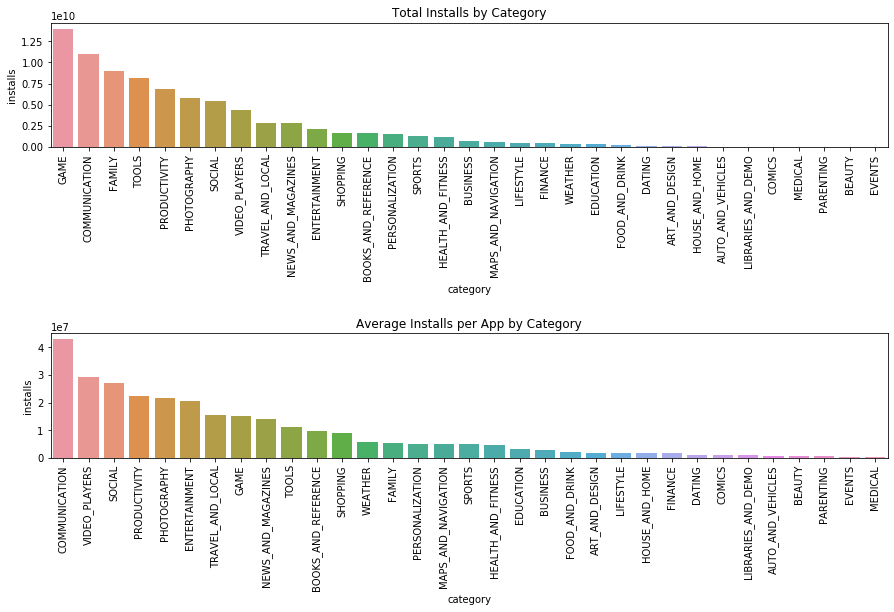

In [26]:
# Create figure
fig, axes = plt.subplots(2,1, figsize=[15,8]);
fig.subplots_adjust(hspace=1.5);

# Plot average number of installs by category
plt.sca(axes[0]);
df_install_category = df.groupby("category").sum().installs.sort_values(ascending=False).reset_index()
sns.barplot(data=df_install_category, x="category", y="installs");
plt.title("Total Installs by Category");
plt.xticks(rotation="vertical");

# Plot total number of installs by category
plt.sca(axes[1]);
df_install_category = df.groupby("category").mean().installs.sort_values(ascending=False).reset_index()
sns.barplot(data=df_install_category, x="category", y="installs");
plt.title("Average Installs per App by Category");
plt.xticks(rotation="vertical");

The top graph indicates which categories are more popular, either in the number of apps available in that category or the popularity of particular apps. There are so many games in the Google Play Store that it's not a surprise for this category to have the most number of installs in this sample. 

The bottom graph indicates whether the apps in the category are popular. Communication is an example of having apps with a high number of installs or users, and these apps include Facebook Messenger or Gmail. 

#### How many paid apps v. free apps are there?

free    0.93
paid    0.07
Name: price_type, dtype: float64

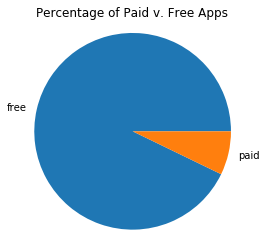

In [39]:
# Plot comparison of paid v. free
df_app = df[["app","price_type"]].drop_duplicates().dropna()
df_app = df_app.price_type.value_counts()
plt.pie(df_app, labels=df_app.index, colors=sns.color_palette(n_colors=2));
plt.axis("square");
plt.title("Percentage of Paid v. Free Apps");
round(df_app/df_app.sum(),2)

93% of apps are free on the Google Play Store (assuming the sample represents the proportion of free v. paid in the entire app store).

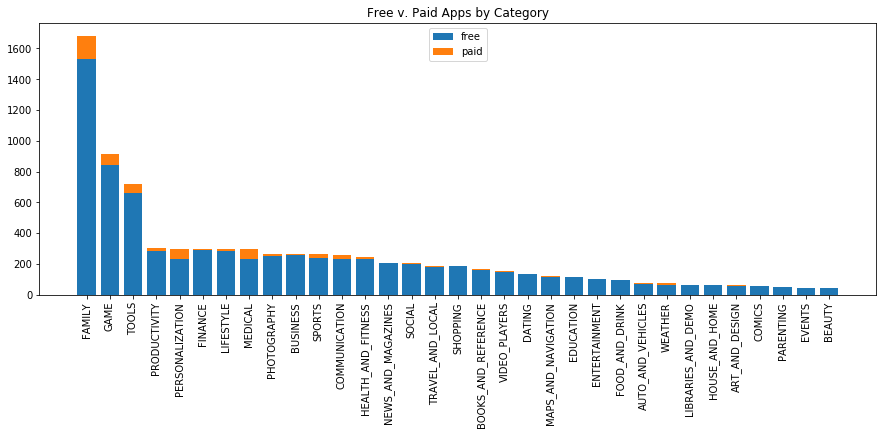

In [41]:
# Plot number of apps per category that are free v. paid
cat1_order = list(df.category.value_counts().index)
cat2_order = ["free","paid"]

plt.figure(figsize=[15,5]);

baselines = np.zeros(len(cat1_order))
# for each second-variable category:
for i in range(len(cat2_order)):
    # isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = df[df['price_type'] == cat2]['category'].value_counts()
    # then plot those counts on top of the accumulated baseline
    plt.bar(x = np.arange(len(cat1_order)), height = inner_counts[cat1_order],
            bottom = baselines);
    baselines += inner_counts[cat1_order]
plt.xticks(np.arange(len(cat1_order)), cat1_order);
plt.legend(cat2_order);
plt.xticks(rotation="vertical");
plt.title("Free v. Paid Apps by Category");

Most apps are free instead of paid. The category with most paid apps include **Family**, **Personalization**, **Medical**, and **Game**. 

#### What's the average price for paid apps?

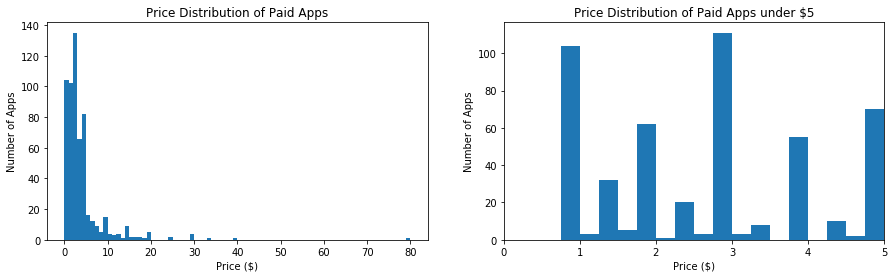

In [28]:
# Create figure
fig, axes = plt.subplots(1, 2, figsize=[15,4]);

# Plot overall paid price distribution
plt.sca(axes[0]);
plt.title("Price Distribution of Paid Apps");
df_price = df[df.price_type == "paid"][["app","price"]].drop_duplicates().dropna()
bin_edges = np.arange(0,df_price.price.max()+1, 1)
plt.hist(df_price.price, bins = bin_edges);
plt.xlabel("Price ($)");
plt.ylabel("Number of Apps");

# Zoom into prices under $5
plt.sca(axes[1]);
plt.title("Price Distribution of Paid Apps under $5");
df_price = df_price[df_price.price < 5]
bin_edges = np.arange(0,df_price.price.max()+1, .25)
plt.hist(df_price.price, bins = bin_edges);
plt.xlim(0,5);
plt.xlabel("Price ($)");
plt.ylabel("Number of Apps");

Most apps are under `$5`. 
They also tend to end with ".99" as a sales tactic (e.g. an app would be `$1.99` instead of `$2`).

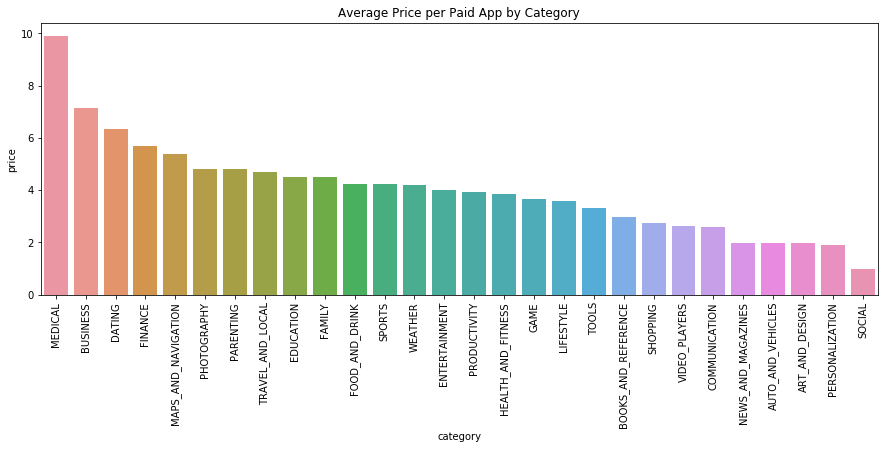

In [44]:
# Plot average price of paid apps by category
plt.figure(figsize=[15,5]);
df_paid_category = df[df.price_type == "paid"].groupby("category").mean().price.sort_values(ascending=False).reset_index()
sns.barplot(data=df_paid_category, x="category",y="price");
plt.title("Average Price per Paid App by Category");
plt.xticks(rotation="vertical");

In [51]:
# Examples of some of these apps
print(df[(df.category == "MEDICAL") & (df.price_type == "paid")].app.head(2))
print(df[(df.category == "BUSINESS") & (df.price_type == "paid")].app.head(2))
print(df[(df.category == "DATING") & (df.price_type == "paid")].app.head(2))
print(df[(df.category == "FINANCE") & (df.price_type == "paid")].app.head(2))

2243    Monash Uni Low FODMAP Diet
2244            iBP Blood Pressure
Name: app, dtype: object
234    TurboScan: scan documents and receipts in PDF
235                   Tiny Scanner Pro: PDF Doc Scan
Name: app, dtype: object
476    Moco+ - Chat, Meet People
477                   Calculator
Name: app, dtype: object
5361          I am Rich Premium Plus
5911    Ba Financial Calculator plus
Name: app, dtype: object


Medical apps are the most expensive averaging just under `$10`. Business, dating, and finance are the next most expensive even though there aren't as many apps out there.

#### Are paid apps better than free apps?

In [53]:
# Compare average rating of paid v free apps
(df[df.price_type == "free"].mean().rating, df[df.price_type == "paid"].mean().rating)

(4.168927506160036, 4.271186440677964)

Free apps average a 4.17 rating, but paid apps average a 4.27 rating.

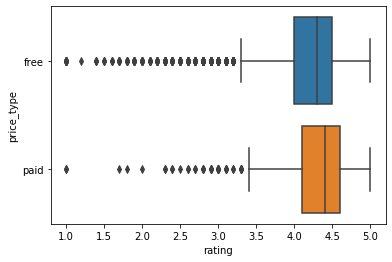

In [56]:
# Plot distribution of ratings by price type
sns.boxplot(data = df, y = 'price_type', x = 'rating');

Both distributions are skewed left but have a similar shape.

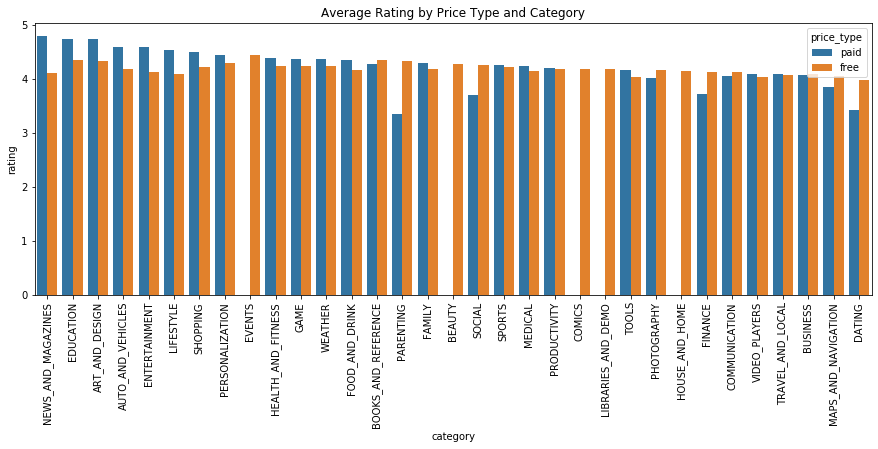

In [78]:
# Plot free v. paid apps' rating by category
plt.figure(figsize=[15,5]);
df_price_rating = df.groupby(["category", "price_type"]).mean().rating.sort_values(ascending=False).reset_index()
sns.barplot(data=df_price_rating, x="category", hue="price_type",y="rating");
plt.title("Average Rating by Price Type and Category");
plt.xticks(rotation="vertical");

**News and Magazines**, **Education**, and **Art and Design** have better ratings with paid apps. **Beauty** and **House and Home** only have ratings for free apps. **Dating** and **Maps and Na